### Imports

In [2]:
!pip install spotipy

In [6]:
!pip install pip install python-dotenv

  Using cached install-1.3.3-py3-none-any.whl (3.1 kB)


In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from diversify.session import SpotifySession

In [2]:
%matplotlib inline

sns.set(rc={'figure.figsize': (12,8)})

warnings.filterwarnings('ignore')

### About Audio Features

| Column   |      Value Type      |  Value Description |
|:----------|:--------------------|:-------------------|
| id | - | The Spotify ID for the track. |
| name | string | Name of the track. |
| artist | string | Artist who plays the track. |
| artist_id | - | The Spotify ID for the artist. |
| album | string | The album where the track is on. |
| album_id | - | The Spotify ID for the album. | 
| popularity | int | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.|
| duration_ms | int | The duration of the track in milliseconds. |
| key | int | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| mode | int | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| acousticness | float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| danceability | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | float | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| instrumentalness | float | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| loudness | float | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| speechiness | float | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| valence | float | 	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | float | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |


### Importing data

- Songs to cluster

In [3]:
df_songs = pd.read_csv('datasets/songs_to_cluster.csv')
df_songs.head(3)

,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,0.411,0.666,0.859,0.000000,8,0.3140,-3.836,1,0.0304,156.990,0.933
1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,0.564,0.707,0.851,0.000094,7,0.3300,-5.008,0,0.0322,153.929,0.871
2,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,0.801,0.299,0.159,0.000000,11,0.0611,-16.540,0,0.0357,183.227,0.180


In [4]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   album             6500 non-null   object 
 1   album_id          6500 non-null   object 
 2   artist            6500 non-null   object 
 3   artist_id         6500 non-null   object 
 4   duration_ms       6500 non-null   int64  
 5   id                6500 non-null   object 
 6   name              6500 non-null   object 
 7   popularity        6500 non-null   int64  
 8   acousticness      6500 non-null   float64
 9   danceability      6500 non-null   float64
 10  energy            6500 non-null   float64
 11  instrumentalness  6500 non-null   float64
 12  key               6500 non-null   int64  
 13  liveness          6500 non-null   float64
 14  loudness          6500 non-null   float64
 15  mode              6500 non-null   int64  
 16  speechiness       6500 non-null   float64


In [5]:
df_songs.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,6.500000e+03,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,2.208090e+05,48.984308,0.293562,0.605050,0.661835,0.101119,5.283692,0.223859,-7.621361,0.641692,0.089147,123.111848,0.540776
std,8.607416e+04,20.803480,0.298453,0.166257,0.232170,0.251975,3.572666,0.209840,4.429930,0.479540,0.089175,28.578793,0.253939
min,4.544000e+04,0.000000,0.000002,0.000000,0.000255,0.000000,0.000000,0.020900,-42.238000,0.000000,0.000000,0.000000,0.000000
25%,1.760972e+05,37.000000,0.022700,0.495000,0.506000,0.000000,2.000000,0.094800,-9.358000,0.000000,0.037800,99.988750,0.340000
50%,2.071930e+05,52.000000,0.193000,0.619000,0.702000,0.000008,5.000000,0.132000,-6.577500,1.000000,0.054200,124.675500,0.548000
75%,2.461378e+05,63.000000,0.513000,0.727000,0.855000,0.005110,8.000000,0.284000,-4.699000,1.000000,0.099325,140.068000,0.750000
max,3.128960e+06,100.000000,0.996000,0.981000,0.999000,0.982000,11.000000,0.989000,0.858000,1.000000,0.904000,210.466000,0.984000


- Users songs

In [6]:
df_user = pd.read_csv('datasets/user_songs/andreaskeete_songs.csv')
df_user.head(3)

,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,valence,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo
0,Pausa,3pWFZKy7JVT0gJYzkjd9aX,42,227251,Pausa,60mJk5aDdrPI4aSVCKNJy9,5 a Seco,1R9QfzgBmhk1spLg3BiU1f,0.0337,0.144,1,0.107,7,0.452,-11.296,0.817,0.000001,0.190,149.111
1,Como Quero Demonstrar,6bUlF5XkOWzh5bLawb4yuL,40,156549,Pausa,60mJk5aDdrPI4aSVCKNJy9,5 a Seco,1R9QfzgBmhk1spLg3BiU1f,0.1920,0.618,1,0.133,2,0.628,-10.215,0.751,0.000213,0.366,86.955
2,Duas Jornadas,21r7NkuUuGEvY0QiUZViDk,43,208703,Pausa,60mJk5aDdrPI4aSVCKNJy9,5 a Seco,1R9QfzgBmhk1spLg3BiU1f,0.0286,0.453,1,0.137,7,0.624,-11.535,0.854,0.000010,0.270,132.962


In [7]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              369 non-null    object 
 1   id                369 non-null    object 
 2   popularity        369 non-null    int64  
 3   duration_ms       369 non-null    int64  
 4   album             369 non-null    object 
 5   album_id          369 non-null    object 
 6   artist            369 non-null    object 
 7   artist_id         369 non-null    object 
 8   speechiness       369 non-null    float64
 9   valence           369 non-null    float64
 10  mode              369 non-null    int64  
 11  liveness          369 non-null    float64
 12  key               369 non-null    int64  
 13  danceability      369 non-null    float64
 14  loudness          369 non-null    float64
 15  acousticness      369 non-null    float64
 16  instrumentalness  369 non-null    float64
 1

In [8]:
df_user.describe()

,popularity,duration_ms,speechiness,valence,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,44.593496,245227.747967,0.053668,0.471569,0.642276,0.233061,5.170732,0.563046,-9.623873,0.374465,0.047608,0.507508,118.530976
std,19.961173,67759.853130,0.045737,0.222148,0.479981,0.234979,3.479069,0.139975,3.403329,0.299902,0.158667,0.212257,28.618373
min,0.000000,55413.000000,0.022500,0.043400,0.000000,0.024400,0.000000,0.198000,-20.923000,0.000005,0.000000,0.034700,53.905000
25%,33.000000,208466.000000,0.031700,0.290000,0.000000,0.098200,2.000000,0.462000,-11.716000,0.087900,0.000001,0.343000,96.094000
50%,45.000000,237941.000000,0.038600,0.456000,1.000000,0.126000,5.000000,0.559000,-9.099000,0.330000,0.000118,0.506000,116.681000
75%,60.000000,272173.000000,0.055500,0.628000,1.000000,0.256000,8.000000,0.659000,-7.169000,0.606000,0.004780,0.651000,135.976000
max,86.000000,610533.000000,0.442000,0.969000,1.000000,0.986000,11.000000,0.894000,-1.940000,0.983000,0.973000,0.982000,203.375000


### Train dataset analysis

- Verifying columns

In [9]:
df_songs.columns

Index(['album', 'album_id', 'artist', 'artist_id', 'duration_ms', 'id', 'name',
       'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')

- Verifying correlations between features

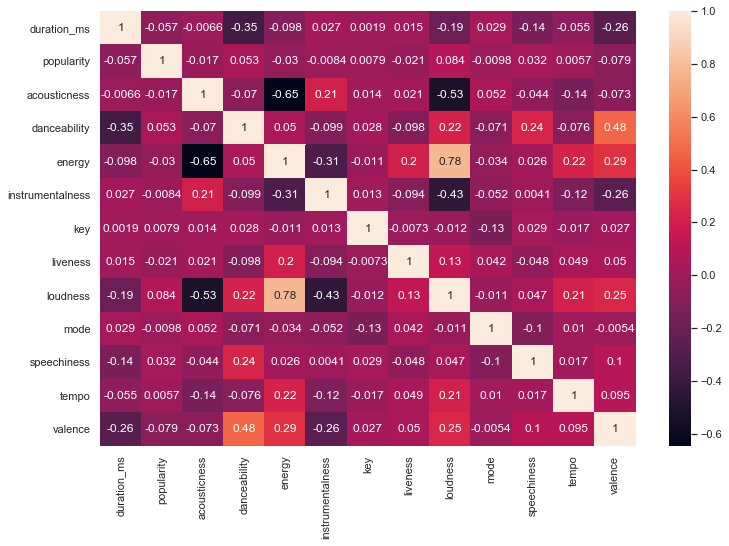

In [10]:
ax = sns.heatmap(df_songs.corr(), annot=True)
plt.show()

- Analyzing the distributions of the continuous features

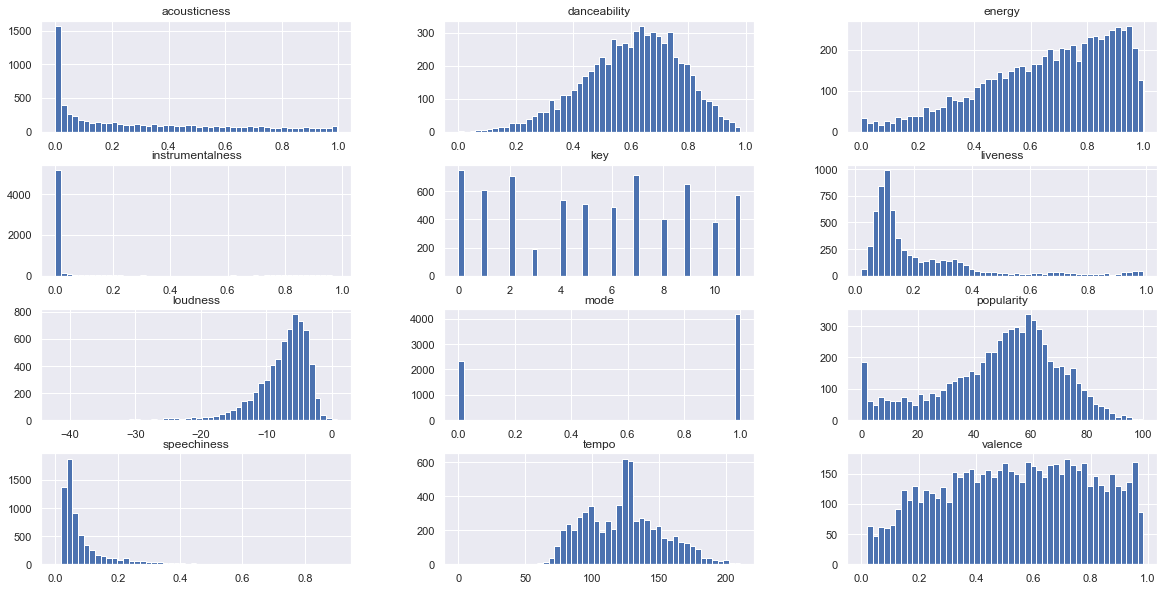

In [11]:
df_songs[['popularity', 'acousticness', 'danceability', 'energy', 
           'instrumentalness', 'key','liveness','loudness', 'mode', 'speechiness',
           'tempo', 'valence']].hist(bins=50, figsize=(20,10))
plt.show()

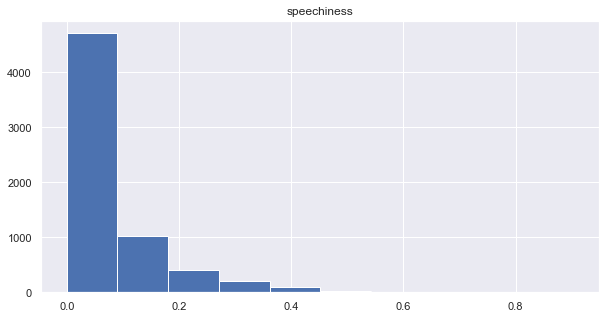

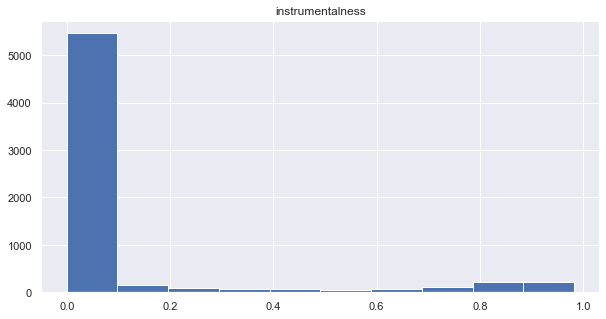

In [12]:
df_songs[['speechiness']].hist(figsize=(10,5))
df_songs[['instrumentalness']].hist(figsize=(10,5))
plt.show()

In [13]:
columns_to_cluster = ['acousticness', 'danceability', 'energy', 
                      'instrumentalness', 'liveness','valence', 'tempo','speechiness', 'loudness']

### Preprocessing data

- Changing the data scale

Using StandardScaler

In [60]:
# Currently using MinMaxScaler, due to minor inertia values in KMeans
ss = StandardScaler()

songs_scaled = ss.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = ss.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [-0.57611656  0.39351789  0.36662849  0.84929458 -0.40133461  0.42960597
  0.85456257 -0.65883238  1.54467758]
Dados de usuários:  [ 0.18737283  2.32094603 -2.65769796 -1.76058298 -0.14301338  0.46196365
 -0.60980366 -0.89574973 -0.57555324]


Using MinMaxScaler

In [14]:
mms = MinMaxScaler()

songs_scaled = mms.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = mms.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [0.41264952 0.67889908 0.85982408 0.         0.30275798 0.94817073
 0.7459162  0.03362832 0.89108038]
Dados de usuários:  [8.31128281e-01 3.64942529e-01 1.63939618e-01 1.18191161e-06
 8.58985025e-02 1.08686258e-01 6.36957249e-01 2.66984505e-02
 5.07137966e-01]


In [15]:
columns_to_cluster_scaled = ['acousticness_scaled', 'danceability_scaled', 
                             'energy_scaled', 'instrumentalness_scaled', 'liveness_scaled'
                             , 'valence_scaled', 'tempo_scaled','speechiness_scaled', 'loudness_scaled']

df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster_scaled)

- Scaled Heatmap

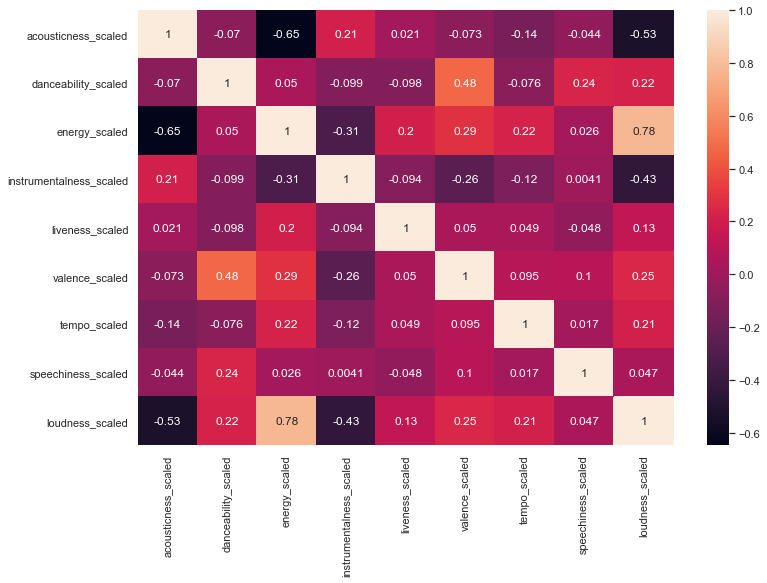

In [16]:
ax = sns.heatmap(df_songs_scaled.corr(), annot=True)
plt.show()

### Training the model

In [17]:
n_clusters = range(2,21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.32015765197940693
Number of Clusters = 3, Silhouette Score = 0.2054776296219524
Number of Clusters = 4, Silhouette Score = 0.21389078841750514
Number of Clusters = 5, Silhouette Score = 0.23389535003124173
Number of Clusters = 6, Silhouette Score = 0.24420048620742066
Number of Clusters = 7, Silhouette Score = 0.2177599549132281
Number of Clusters = 8, Silhouette Score = 0.20984225070835294
Number of Clusters = 9, Silhouette Score = 0.20917421084771196
Number of Clusters = 10, Silhouette Score = 0.18410754772810878
Number of Clusters = 11, Silhouette Score = 0.19615938137252129
Number of Clusters = 12, Silhouette Score = 0.17896734623237984
Number of Clusters = 13, Silhouette Score = 0.1699004360096766
Number of Clusters = 14, Silhouette Score = 0.16498815421884908
Number of Clusters = 15, Silhouette Score = 0.16418597526828163
Number of Clusters = 16, Silhouette Score = 0.16340598517849944
Number of Clusters = 17, Silhouette Score = 0.16327

- Silhouette score plot

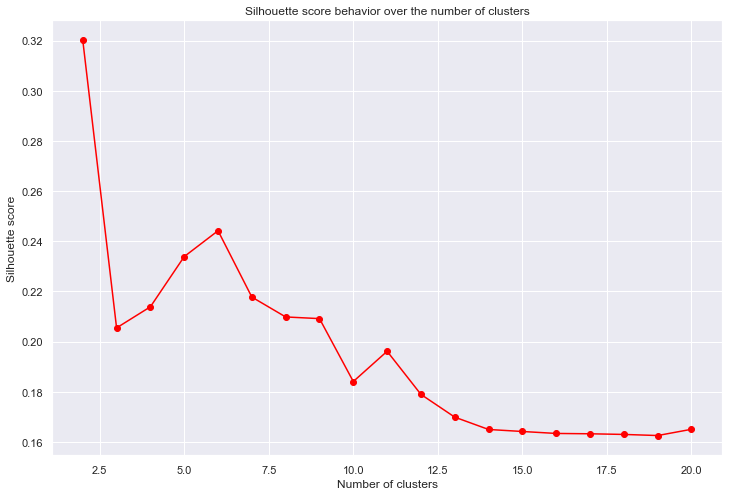

In [18]:
plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score behavior over the number of clusters')
plt.show()

- Elbow method plot

In [19]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 1890.0300135936684
Number of Clusters = 3, Sum of Squared Distances = 1584.2649671411768
Number of Clusters = 4, Sum of Squared Distances = 1369.9010801290715
Number of Clusters = 5, Sum of Squared Distances = 1191.668121326006
Number of Clusters = 6, Sum of Squared Distances = 1067.4264031608
Number of Clusters = 7, Sum of Squared Distances = 977.385114428353
Number of Clusters = 8, Sum of Squared Distances = 913.9660727893529
Number of Clusters = 9, Sum of Squared Distances = 875.7641110256023
Number of Clusters = 10, Sum of Squared Distances = 838.9887741203255
Number of Clusters = 11, Sum of Squared Distances = 803.7681812463579
Number of Clusters = 12, Sum of Squared Distances = 775.3007898297905
Number of Clusters = 13, Sum of Squared Distances = 752.7194301306885
Number of Clusters = 14, Sum of Squared Distances = 734.5416628659583
Number of Clusters = 15, Sum of Squared Distances = 716.4523091247819
Number of Clusters = 16, Sum

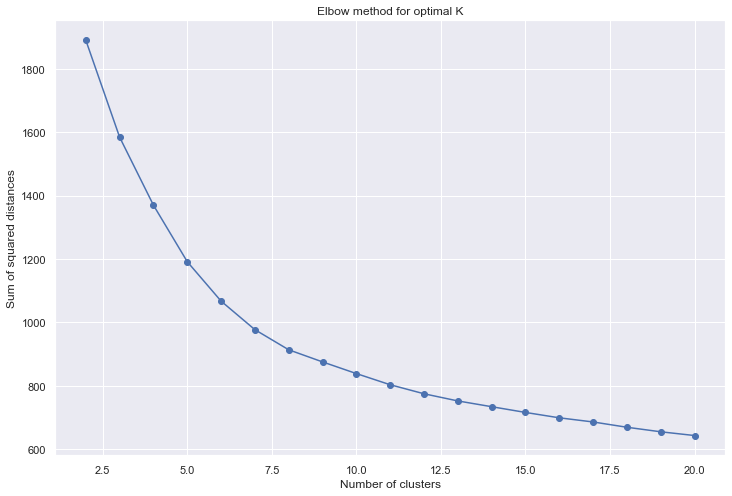

In [20]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

- Fixing the number of clusters

In [21]:
k=6

model = KMeans(n_clusters=k, random_state=42).fit(songs_scaled)
pred = model.predict(songs_scaled)
print('10 first clusters: ', model.labels_[:10])

10 first clusters:  [3 3 1 2 1 1 1 1 2 2]


### Visualizing the clusters

- Amount of songs per cluster

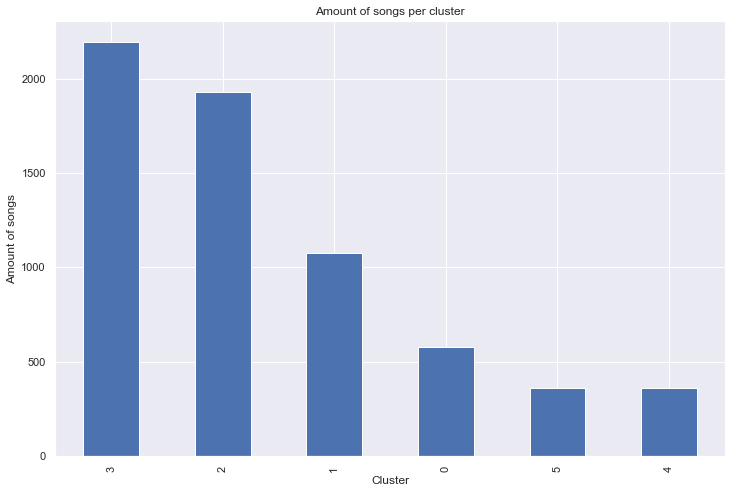

In [22]:
df_songs_scaled['cluster'] = model.labels_

df_songs_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs per cluster')
plt.show()

In [23]:
display(df_songs_scaled['cluster'].value_counts())
minor_cluster = df_songs_scaled['cluster'].value_counts().tail(1)
print("Amount of songs in the smallest cluster: ", int(minor_cluster.values))

3    2194
2    1926
1    1075
0     580
5     363
4     362
Name: cluster, dtype: int64

Amount of songs in the smallest cluster:  362


- Sampling songs from each cluster

In [24]:
df_songs_joined = pd.concat([df_songs,df_songs_scaled], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
0,Redondo,Pretty Baby,Pretty Baby
0,Diego & Victor Hugo,Prefiro Nem Perguntar - Ao Vivo,Prefiro Nem Perguntar (Ao Vivo)
0,Ferrugem,Pra você acreditar - Ao vivo,Pra você acreditar (Ao vivo)
0,Cavaleiros do Forró,Saideira - Ao Vivo,Cavaleiros Infinity
0,Diante do Trono,Outra Vez - Ao Vivo,Outra Vez (Ao Vivo)
0,Kideko,What Is It,What Is It
0,Alceu Valença,Anunciação - Ao Vivo,"O Grande Encontro 20 Anos: Alceu, Elba e Geral..."
0,Jorge Sargento,Templo Sagrado,Parcerias
0,Riverson Vianna,Vamos Celebrar,Vamos Celebrar


,artist,name,album
cluster,,,
1,John Mayer,"Free Fallin' - Live at the Nokia Theatre, Los ...",Where the Light Is: John Mayer Live In Los Ang...
1,Isobel Anderson,Feathers,Cold Water Songs
1,Hungria Hip Hop,Um Pedido,Um Pedido
1,Hungria Hip Hop,Coração de Aço - Acústico,Coração de Aço (Acústico)
1,Sorriso Maroto,Eu Já Te Quis um Dia - Acústico,Eu Já Te Quis um Dia (Acústico)
1,Linda Ronstadt,Blue Bayou,Simple Dreams
1,Jason Mraz,Love Someone,Love Someone
1,Roberta Campos,De Janeiro a Janeiro,Varrendo a Lua (Deluxe Edition)
1,Lucas Santtana,Ninguém Solta a Mão de Ninguém,Ninguém Solta a Mão de Ninguém


,artist,name,album
cluster,,,
2,GV3,Já Não Vivo Eu - Michaell D Remix,Já Não Vivo Eu: Remixes
2,Time Bomb Girls,Quando Eu Crescer,Quando Eu Crescer
2,phem,SWEATER,SWEATER
2,Kalli,Kallidade,Kallidade
2,D.O.D,According To Me - Cedric Gervais Remix,According To Me (Remixes)
2,*NSYNC,This I Promise You,No Strings Attached
2,Broadside,Empty,King of Nothing / Empty
2,Vou pro Sereno,Logo Dou um Jeito,É Isso que Eu Te Falo
2,Emeli Sandé,Next To Me,Our Version Of Events


,artist,name,album
cluster,,,
3,Sunflower Bean,Come For Me,Come For Me
3,Heart,Barracuda,Little Queen
3,Dondoka,Tira Meu Nome da Boca,Sintonia (Uma Serie Original Netflix Sintonia ...
3,MK,Back & Forth,Back & Forth
3,Psirico,Elas Gostam (Popa da Bunda) - Ao Vivo,Popa da Bunda (Ao Vivo)
3,Matheus Moraes,Desafoga,Desafoga
3,Tim Maia,"Você E Eu, Eu E Você (Juntinhos)",Tim Universal Maia
3,Racionais MC's,Qual Mentira Vou Acreditar,Sobrevivendo no Inferno
3,TWICE,Feel Special,Feel Special


,artist,name,album
cluster,,,
4,M83,Midnight City - Eric Prydz Private Remix,Midnight City (Eric Prydz Private Remix)
4,Dubdogz,Techno Prank,Techno Prank
4,Leandro Da Silva,Chicaboom,Chicaboom
4,mago,grnsh,grnsh
4,Manamera,Monkey Business,Monkey Business
4,The Cult,She Sells Sanctuary,Pure Cult
4,Rusko,Everyday - Netsky Remix,Everyday / Lick The Lizard EP
4,Pryda,Allein,Eric Prydz Presents Pryda
4,Cidade Dormitório,Homo Erectus Plus,Homo Erectus Plus


,artist,name,album
cluster,,,
5,Barnes Blvd.,I Have Love for Everyone Besides Myself.,Last Summer
5,n o r m a l,cielo,cielo
5,Dmitri Shostakovich,"The Gadfly Suite, Op. 97a: VIII. Romance",Soft Classical Music for Sleeping
5,Slumberville,Aconcagua,Aconcagua
5,Archive,Erase - Nico Casal Remix,Erase (Nico Casal Remix)
5,A L E X,Proud of You,"Growing Up, Vol. 2"
5,Knowmadic,Hydrangea,Hydrangea
5,Franz Liszt,"Années de pèlerinage, 1ère année ""Suisse"", S. ...","Liszt: Annees De Pelerinage, Vol. 1"
5,Kasper Lindmark,Plant,While You Were Away


### Radar chart from each cluster

Made with the help from:
- [jkwd - Favorite songs EDA.ipynb](https://github.com/jkwd/spotify/blob/master/Code/Favourite%20songs%20EDA.ipynb)
- [#392 Use faceting for Radar chart](https://python-graph-gallery.com/392-use-faceting-for-radar-chart/)

In [25]:
rename_columns = dict(zip(columns_to_cluster_scaled,columns_to_cluster))

df_radar = df_songs_scaled.groupby('cluster')[columns_to_cluster_scaled].mean().reset_index().rename(columns=rename_columns)
df_radar

,cluster,acousticness,danceability,energy,instrumentalness,liveness,valence,tempo,speechiness,loudness
0,0,0.376635,0.587551,0.762863,0.009957,0.771969,0.609622,0.598825,0.089531,0.832033
1,1,0.674586,0.584091,0.412824,0.023225,0.136853,0.430153,0.558098,0.079978,0.739693
2,2,0.060827,0.538063,0.780904,0.021040,0.172998,0.388155,0.604021,0.086760,0.844167
3,3,0.235609,0.724433,0.719496,0.010246,0.146978,0.792740,0.593077,0.120246,0.830173
4,4,0.094904,0.647521,0.712161,0.753882,0.185339,0.446414,0.582117,0.092124,0.799193
5,5,0.836771,0.496416,0.217714,0.833793,0.124204,0.296817,0.494799,0.106930,0.569610


In [26]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    #ax = plt.subplot(4,ceil(num_clusters/4),row+1, polar=True, )
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

Calling function to plot the radar

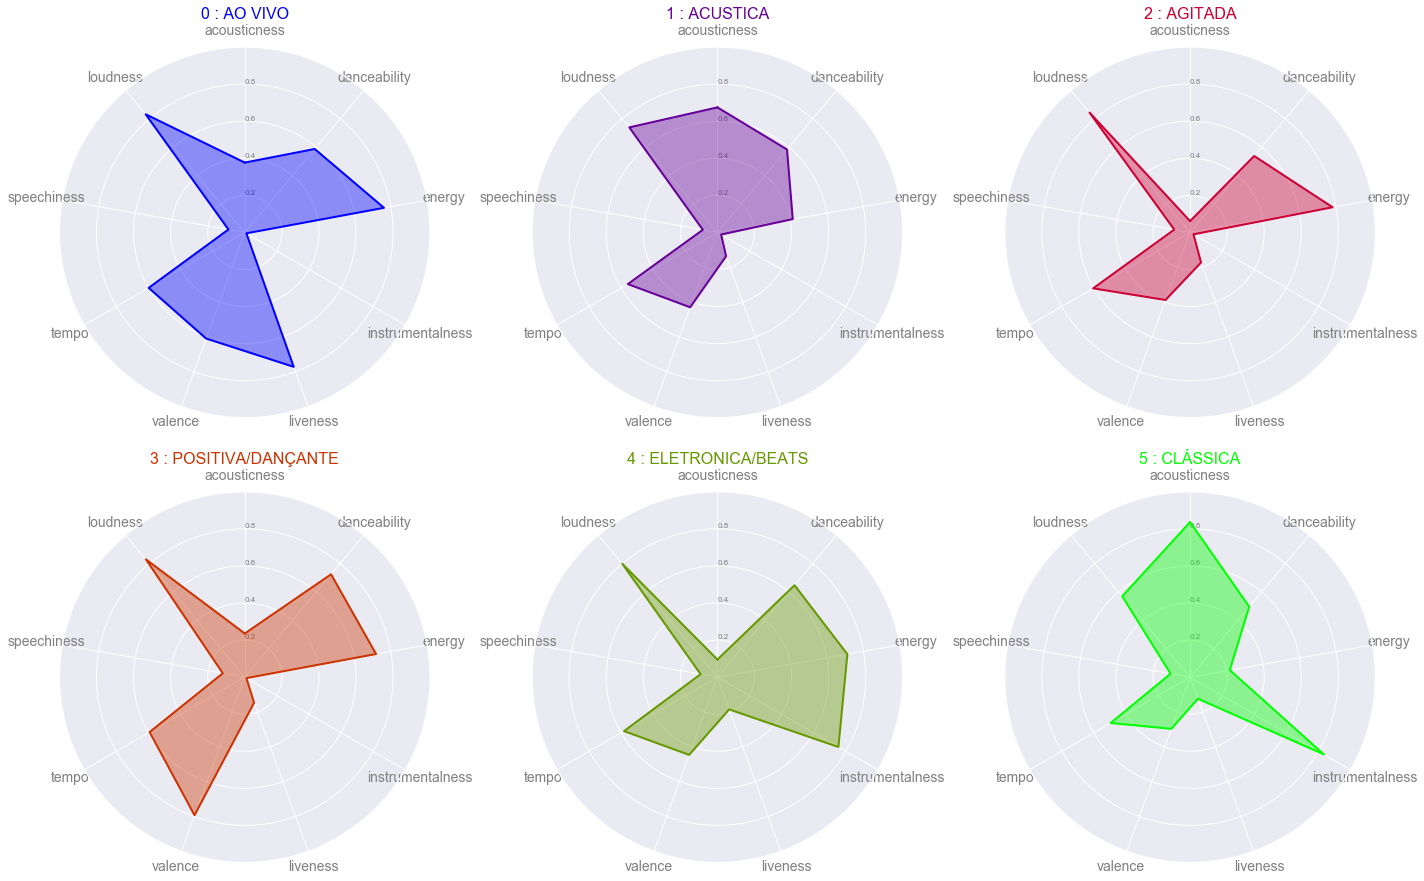

In [27]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(df_radar.index))

# Create cluster name
title_list = ['AO VIVO', 'ACUSTICA', 'AGITADA', 'POSITIVA/DANÇANTE', 
              'ELETRONICA/BEATS', 'CLÁSSICA']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

### Applying PCA to visualize the clusters

In [189]:
pca = PCA(n_components=3, random_state=42)
songs_pca = pca.fit_transform(songs_scaled)
pca.explained_variance_ratio_.sum()

0.7051989976398642

In [190]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,C3,cluster
0,-0.228295,-0.386727,-0.006859,3
1,-0.103194,-0.433030,-0.061114,3
2,0.733545,0.031271,-0.296234,1
3,0.037701,0.044361,-0.019716,2
4,0.134747,-0.156429,0.057400,1


- Undersampling clusters

In [191]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

5    362
3    362
1    362
4    362
2    362
0    362
Name: cluster, dtype: int64

- Visualizing clusters in 2 dimensions

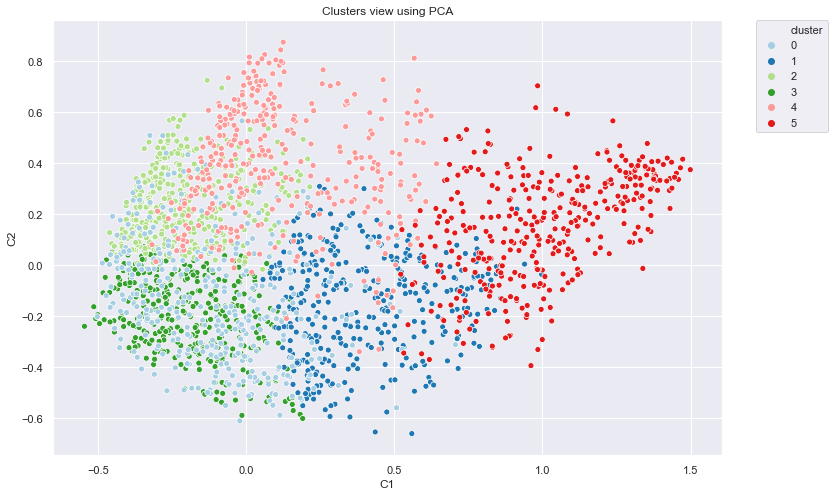

In [192]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using PCA')
plt.show()

- Visualizing clusters in 3 dimensions

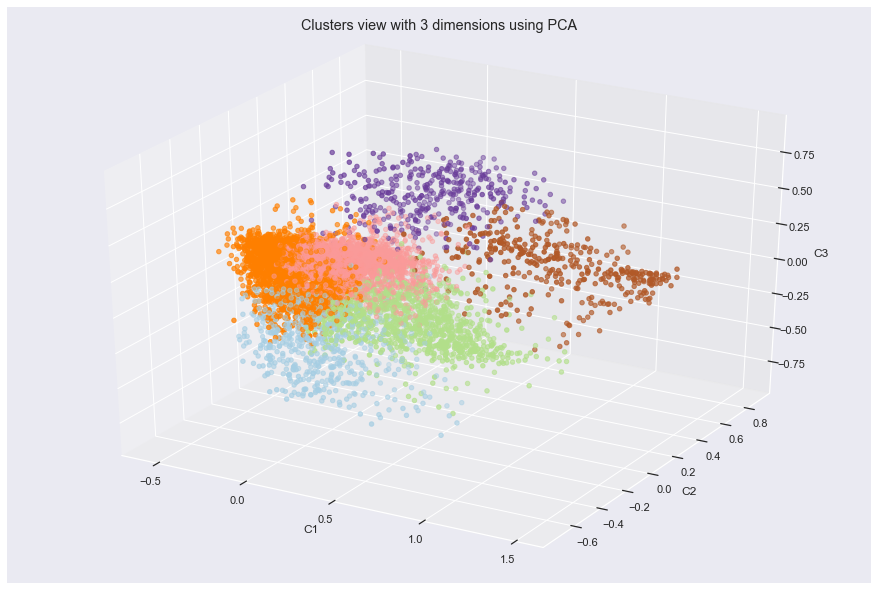

In [193]:
fig = plt.figure()
fig.suptitle('Clusters view with 3 dimensions using PCA')
ax = Axes3D(fig)

ax.scatter(df_pca['C1'], df_pca['C2'], df_pca['C3'],
           c=df_pca['cluster'], cmap='Paired')

ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.show()

### Applying t-SNE to visualizing the clusters

In [194]:
#tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42, learning_rate=190)
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
songs_tsne = tsne.fit_transform(songs_scaled)

In [195]:
df_tsne = pd.DataFrame(songs_tsne, columns=['C1', 'C2'])
df_tsne['cluster'] = model.labels_
df_tsne.head()

,C1,C2,cluster
0,-43.276314,18.159773,3
1,-44.235825,20.816196,3
2,37.856091,38.672852,1
3,15.184397,9.154082,2
4,7.860262,31.032217,1


- Undersampling clusters

In [196]:
sampled_clusters_tsne = pd.DataFrame()

for c in df_tsne.cluster.unique():
    df_cluster_sampled_tsne = df_tsne[df_tsne.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_tsne = pd.concat([sampled_clusters_tsne,df_cluster_sampled_tsne], axis=0)
sampled_clusters_tsne.cluster.value_counts()

5    362
3    362
1    362
4    362
2    362
0    362
Name: cluster, dtype: int64

- Visualizing clusters in 2 dimensions

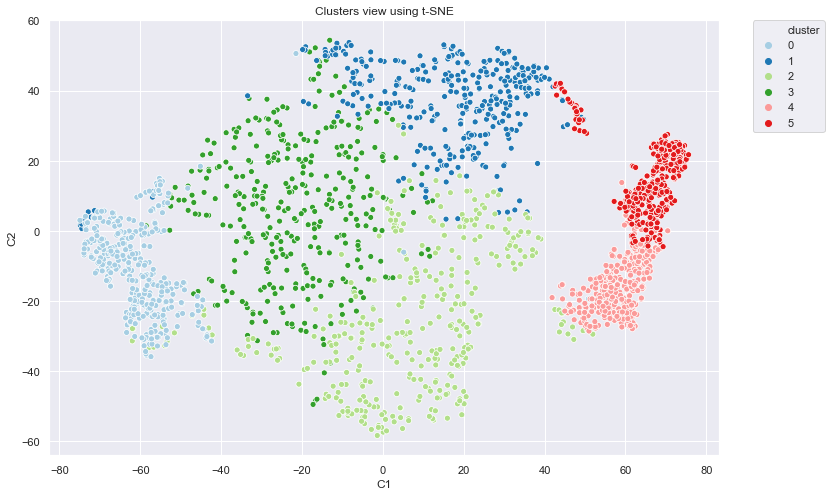

In [197]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_tsne, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using t-SNE')
plt.show()

### Predicting users clusters

In [28]:
user_pred = model.predict(user_scaled)
print('10 first users clusters: ', user_pred[:10])

10 first users clusters:  [1 1 1 1 1 1 1 1 1 1]


- Amount of songs in the users clusters

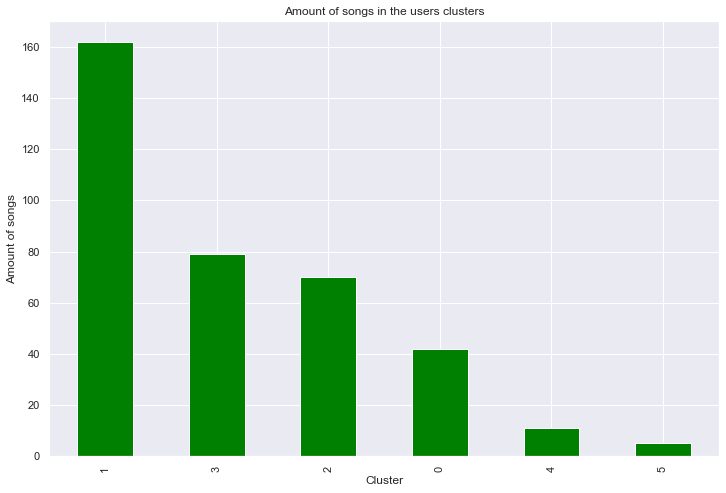

In [29]:
user_cluster = pd.DataFrame(user_scaled, columns=columns_to_cluster_scaled)
user_cluster['cluster'] = user_pred

user_cluster['cluster'].value_counts().plot(kind='bar', color='green')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs in the users clusters')
plt.show()

- Sample of songs in each cluster

In [30]:
df_user_songs_joined = pd.concat([df_user,user_cluster], axis=1).set_index('cluster')
for cluster in user_cluster['cluster'].unique():
    display(df_user_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
1,Waker,So Many Times,This Is Waker
1,Os Paralamas Do Sucesso,Aonde Quer Que Eu Vá,Arquivo II 1991 - 2000
1,5 a Seco,Centro,Pausa
1,O Terno,Passado / Futuro,<atrás/além>
1,Charlie Puth,Suffer,Nine Track Mind (Deluxe Edition)
1,5 a Seco,"Ela, Ele e Eu",Síntese
1,Seu Jorge,Problema Social,Ana E Jorge
1,Keane,I’m Not Leaving,Cause And Effect (Deluxe)
1,5 a Seco,Vai Vendo,Pausa


,artist,name,album
cluster,,,
3,Jamie Cullum,Taller,Taller
3,Djavan,Flor de Lis,A Voz e o Violão
3,The Last Shadow Puppets,The Bourne Identity,Everything You've Come To Expect
3,Stevie Ray Vaughan,Crossfire,In Step
3,Arctic Monkeys,Four Out Of Five - Recorded at Electric Lady S...,Spotify Singles
3,Farofa Carioca,São Gonça,Welcome To COPACABANA - The Brazilian Melting Pop
3,Lucian,Do My Thing (feat. Philosofie),Do My Thing (feat. Philosofie)
3,Jamie Cullum,Usher,Taller
3,Waker,Corbett's Place,This Is Waker


,artist,name,album
cluster,,,
2,Jamie Cullum,Wheels,The Pursuit
2,The Last Shadow Puppets,Bad Habits,Everything You've Come To Expect
2,Waker,False Calls,False Calls
2,Adele,I Miss You,25
2,It's Different,Peace of Mind,Peace of Mind
2,The Last Shadow Puppets,Used To Be My Girl,Everything You've Come To Expect
2,The Last Shadow Puppets,The Dream Synopsis,Everything You've Come To Expect
2,John Mayer,Heartbreak Warfare,Battle Studies
2,The Police,Synchronicity I - Remastered 2003,Synchronicity (Remastered)


,artist,name,album
cluster,,,
0,Tiago Iorc,Mil Razões - Ao Vivo,Acústico MTV Tiago Iorc (Ao Vivo)
0,Lulu Santos,Apenas Mais uma de Amor,Lulu Acústico
0,Tiago Iorc,Um Dia Após O Outro - Ao Vivo,Acústico MTV Tiago Iorc (Ao Vivo)
0,John Mayer,Who Did You Think I Was - Live at the Nokia Th...,Where the Light Is: John Mayer Live In Los Ang...
0,Tiago Iorc,Do Que Você Tem Medo - Ao Vivo,Acústico MTV Tiago Iorc (Ao Vivo)
0,Tiago Iorc,Coisa Linda - Ao Vivo,Acústico MTV Tiago Iorc (Ao Vivo)
0,John Mayer,"Come When I Call - Live at the Nokia Theatre, ...",Where the Light Is: John Mayer Live In Los Ang...
0,5 a Seco,Vou Mandar Pastar,Ao Vivo No Auditório Ibirapuera
0,Tiago Iorc,Amei Te Ver - Ao Vivo,Acústico MTV Tiago Iorc (Ao Vivo)


,artist,name,album
cluster,,,
5,Stevie Ray Vaughan,Little Wing,Couldn't Stand The Weather (Legacy Edition)
5,O Terno,O Bilhete,<atrás/além>
5,Stevie Ray Vaughan,Tin Pan Alley (AKA Roughest Place in Town),Couldn't Stand The Weather (Legacy Edition)
5,Stevie Ray Vaughan,Lenny,Texas Flood (Legacy Edition)
5,Tame Impala,Gossip,Currents


,artist,name,album
cluster,,,
4,Stevie Ray Vaughan,Testify,Texas Flood (Legacy Edition)
4,Stevie Ray Vaughan And Double Trouble with Jef...,Goin' Down - Live,"Solos, Sessions & Encores"
4,Tribal Tech,Fight the Giant,Tribal Tech
4,Stevie Ray Vaughan,Rude Mood,Texas Flood (Legacy Edition)
4,Joe Satriani,Crystal Planet,Crystal Planet
4,Stevie Ray Vaughan,Stang's Swang,Couldn't Stand The Weather (Legacy Edition)
4,Joe Satriani,Love Thing,Crystal Planet
4,Stevie Ray Vaughan,Scuttle Buttin',Couldn't Stand The Weather (Legacy Edition)
4,Tribal Tech,Torque,Illicit


### Recommending songs

- Analysing the percentage of songs per cluster

In [31]:
df_user_songs_joined.reset_index(inplace=True)
cluster_pct = df_user_songs_joined.cluster.value_counts(normalize=True)*20

if int(cluster_pct.round(0).sum()) < 20:
    cluster_pct[cluster_pct < 0.5] = cluster_pct[cluster_pct < 0.5] + 1.0
    
display(cluster_pct)
print('Total songs: ', int(cluster_pct.round(0).sum()))

1    8.780488
3    4.281843
2    3.794038
0    2.276423
4    0.596206
5    0.271003
Name: cluster, dtype: float64

Total songs:  20


In [32]:
df_songs_joined.reset_index(inplace=True)
df_songs_joined.head(3)

,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,valence,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,valence_scaled,tempo_scaled,speechiness_scaled,loudness_scaled
0,3,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,0.411,...,0.933,0.412650,0.678899,0.859824,0.000000,0.302758,0.948171,0.745916,0.033628,0.891080
1,3,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,0.564,...,0.871,0.566264,0.720693,0.851814,0.000095,0.319285,0.885163,0.731372,0.035619,0.863885
2,1,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,0.801,...,0.180,0.804217,0.304791,0.158944,0.000000,0.041525,0.182927,0.870578,0.039491,0.596297


- Adding the percentage to the users dataset

In [33]:
df_user_songs_joined['cluster_pct'] = df_user_songs_joined['cluster'].apply(lambda c: cluster_pct[c])
df_user_songs_joined.drop(columns=columns_to_cluster_scaled, inplace=True)
df_user_songs_joined.head(3)

,cluster,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,...,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo,cluster_pct
0,1,Pausa,3pWFZKy7JVT0gJYzkjd9aX,42,227251,Pausa,60mJk5aDdrPI4aSVCKNJy9,5 a Seco,1R9QfzgBmhk1spLg3BiU1f,0.0337,...,1,0.107,7,0.452,-11.296,0.817,0.000001,0.190,149.111,8.780488
1,1,Como Quero Demonstrar,6bUlF5XkOWzh5bLawb4yuL,40,156549,Pausa,60mJk5aDdrPI4aSVCKNJy9,5 a Seco,1R9QfzgBmhk1spLg3BiU1f,0.1920,...,1,0.133,2,0.628,-10.215,0.751,0.000213,0.366,86.955,8.780488
2,1,Duas Jornadas,21r7NkuUuGEvY0QiUZViDk,43,208703,Pausa,60mJk5aDdrPI4aSVCKNJy9,5 a Seco,1R9QfzgBmhk1spLg3BiU1f,0.0286,...,1,0.137,7,0.624,-11.535,0.854,0.000010,0.270,132.962,8.780488


- Getting mixed samples from the original dataset and inserting in a new playlist, based on the percentage of songs present in each user cluster

In [34]:
playlist = pd.DataFrame()

for ncluster, pct in cluster_pct.items():
    songs = df_songs_joined[df_songs_joined['cluster'] == ncluster].sample(n=int(round(pct, 0)))
    playlist = pd.concat([playlist,songs], ignore_index=True)
    if len(playlist) > 20 :
        flag = 20 - len(playlist)
        playlist = playlist[:flag]
playlist.head(3)

,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,valence,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,valence_scaled,tempo_scaled,speechiness_scaled,loudness_scaled
0,1,French Impressions,5FUPAG4ZjlOSJf0t3uITB7,César Franck,1C3sffOOvQNUwg4YIsvKqy,364093,0xX7kREWmOGBWzYNcpZwRN,"Violin Sonata in A Major, FWV 8: Allegretto po...",56,0.958,...,0.179,0.961847,0.254842,0.134914,0.035540,0.027683,0.181911,0.448548,0.053982,0.548148
1,1,O Grande Encontro II,46lRYlN7fENR0jYkWzjmqQ,Elba Ramalho,4ph6Bt1mkDlmf32PSvRa8A,173026,69WUlAhRkKerjAxMdyaUlZ,Ai Que Saudade D'Ocê,56,0.356,...,0.413,0.357429,0.737003,0.596494,0.000000,0.133354,0.419715,0.532727,0.076549,0.745174
2,1,Enciclopédia Musical Brasileira,5Inb6sTfsYiZnOoELmZqbb,Geraldo Vandre,47ucOGPLBaYYcUcTNI1Szg,361360,78lTDfRCqtxSvByIRMiXF2,Pra Não Dizer Que Não Falei Das Flores,48,0.353,...,0.306,0.354416,0.535168,0.284102,0.101527,0.109596,0.310976,0.542582,0.052212,0.627251


### User EDA vs New playlist

In [35]:
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cluster                  20 non-null     int64  
 1   album                    20 non-null     object 
 2   album_id                 20 non-null     object 
 3   artist                   20 non-null     object 
 4   artist_id                20 non-null     object 
 5   duration_ms              20 non-null     int64  
 6   id                       20 non-null     object 
 7   name                     20 non-null     object 
 8   popularity               20 non-null     int64  
 9   acousticness             20 non-null     float64
 10  danceability             20 non-null     float64
 11  energy                   20 non-null     float64
 12  instrumentalness         20 non-null     float64
 13  key                      20 non-null     int64  
 14  liveness                 20 

In [36]:
playlist[['name', 'artist', 'album', 'cluster']]

,name,artist,album,cluster
0,"Violin Sonata in A Major, FWV 8: Allegretto po...",César Franck,French Impressions,1
1,Ai Que Saudade D'Ocê,Elba Ramalho,O Grande Encontro II,1
2,Pra Não Dizer Que Não Falei Das Flores,Geraldo Vandre,Enciclopédia Musical Brasileira,1
3,Fé Inabalável,Israel Salazar,Fé Inabalável,1
4,Top to Toe,Fenne Lily,Top to Toe,1
5,Stay With Me,Sam Smith,In The Lonely Hour,1
6,Só fica,Paula Mattos,Livre,1
7,The Look,Metronomy,The English Riviera,1
8,Siren Song,The Brother Brothers,Siren Song,1
9,Dança do Creu,Mc Creu,Funk do Brasil (Danse Club No. 1),3


In [37]:
playlist.describe()

,cluster,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,...,valence,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,valence_scaled,tempo_scaled,speechiness_scaled,loudness_scaled
count,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1.650000,252762.4500,47.800000,0.370270,0.555550,0.586450,5.486671e-02,4.900000,0.197220,-8.467150,...,0.447850,0.371756,0.566310,0.586932,5.587241e-02,0.182130,0.455132,0.548754,0.070216,0.783619
std,1.089423,79782.1352,19.795268,0.326096,0.187003,0.267761,1.757263e-01,3.864821,0.180039,4.352646,...,0.212847,0.327406,0.190625,0.268097,1.789473e-01,0.185972,0.216308,0.123086,0.048760,0.100999
min,0.000000,140694.0000,0.000000,0.000005,0.189000,0.135000,0.000000e+00,0.000000,0.047700,-18.615000,...,0.175000,0.000003,0.192661,0.134914,0.000000e+00,0.027683,0.177846,0.371024,0.032965,0.548148
25%,1.000000,182697.2500,44.000000,0.067175,0.458250,0.411750,9.525000e-07,2.000000,0.113500,-10.803500,...,0.285000,0.067443,0.467125,0.412012,9.699593e-07,0.095651,0.289634,0.456406,0.040155,0.729406
50%,1.000000,245140.0000,54.500000,0.305000,0.555500,0.594000,2.005000e-04,3.500000,0.127500,-7.539500,...,0.424000,0.306224,0.566259,0.594491,2.041752e-04,0.110113,0.430894,0.537655,0.057909,0.805144
75%,2.250000,323528.5000,60.750000,0.584750,0.698000,0.756000,3.392500e-02,9.000000,0.175250,-5.318500,...,0.634750,0.587098,0.711519,0.756695,3.454684e-02,0.159436,0.645071,0.602154,0.078180,0.856680
max,4.000000,370866.0000,69.000000,0.988000,0.854000,0.981000,7.930000e-01,11.000000,0.811000,-2.309000,...,0.809000,0.991968,0.870540,0.981977,8.075356e-01,0.816135,0.822154,0.825188,0.247788,0.926513


- Comparing features between user x playlist

In [38]:
def plot_recomendations_similarities(data, variables):
    root = int(np.ceil(np.sqrt(len(variables))))
    fig, axis = plt.subplots(nrows=root, ncols=root, figsize=(15, 15))
    
    numeric_categories = ["0.0 - 0.2",
                           "0.2 - 0.4",
                           "0.4 - 0.6",
                           "0.6 - 0.8",
                           "0.8 - 1.0",
                           ]
    fig.suptitle('Comparing distributions for the songs features')
    for idx, column in enumerate(variables):
        i, j = idx % root, idx // root
        ax = axis[j][i]
        
        grouped = data.groupby('user')[[column, 'user']]
        
        for user, group in grouped:
            sns.distplot(group[column], ax=ax, label=user, bins=20)
        ax.legend()
    plt.show()

In [39]:
df_user_songs_joined['user'] = 'User'
playlist['user'] = 'Playlist'

user = df_user_songs_joined.drop(columns='cluster_pct')

display(user.head(1))
playlist.head(1)

,cluster,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,...,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo,user
0,1,Pausa,3pWFZKy7JVT0gJYzkjd9aX,42,227251,Pausa,60mJk5aDdrPI4aSVCKNJy9,5 a Seco,1R9QfzgBmhk1spLg3BiU1f,0.0337,...,1,0.107,7,0.452,-11.296,0.817,0.000001,0.19,149.111,User


,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,valence_scaled,tempo_scaled,speechiness_scaled,loudness_scaled,user
0,1,French Impressions,5FUPAG4ZjlOSJf0t3uITB7,César Franck,1C3sffOOvQNUwg4YIsvKqy,364093,0xX7kREWmOGBWzYNcpZwRN,"Violin Sonata in A Major, FWV 8: Allegretto po...",56,0.958,...,0.961847,0.254842,0.134914,0.03554,0.027683,0.181911,0.448548,0.053982,0.548148,Playlist


In [40]:
user_sampled = pd.DataFrame(columns=user.columns)

for c in playlist.cluster.unique():
    user_sampled = user_sampled.append(user[user.cluster == c].sample(n=playlist[playlist.cluster == c].count().values[0]))
user_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 192 to 364
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cluster           20 non-null     object 
 1   name              20 non-null     object 
 2   id                20 non-null     object 
 3   popularity        20 non-null     object 
 4   duration_ms       20 non-null     object 
 5   album             20 non-null     object 
 6   album_id          20 non-null     object 
 7   artist            20 non-null     object 
 8   artist_id         20 non-null     object 
 9   speechiness       20 non-null     float64
 10  valence           20 non-null     float64
 11  mode              20 non-null     object 
 12  liveness          20 non-null     float64
 13  key               20 non-null     object 
 14  danceability      20 non-null     float64
 15  loudness          20 non-null     float64
 16  acousticness      20 non-null     float64
 

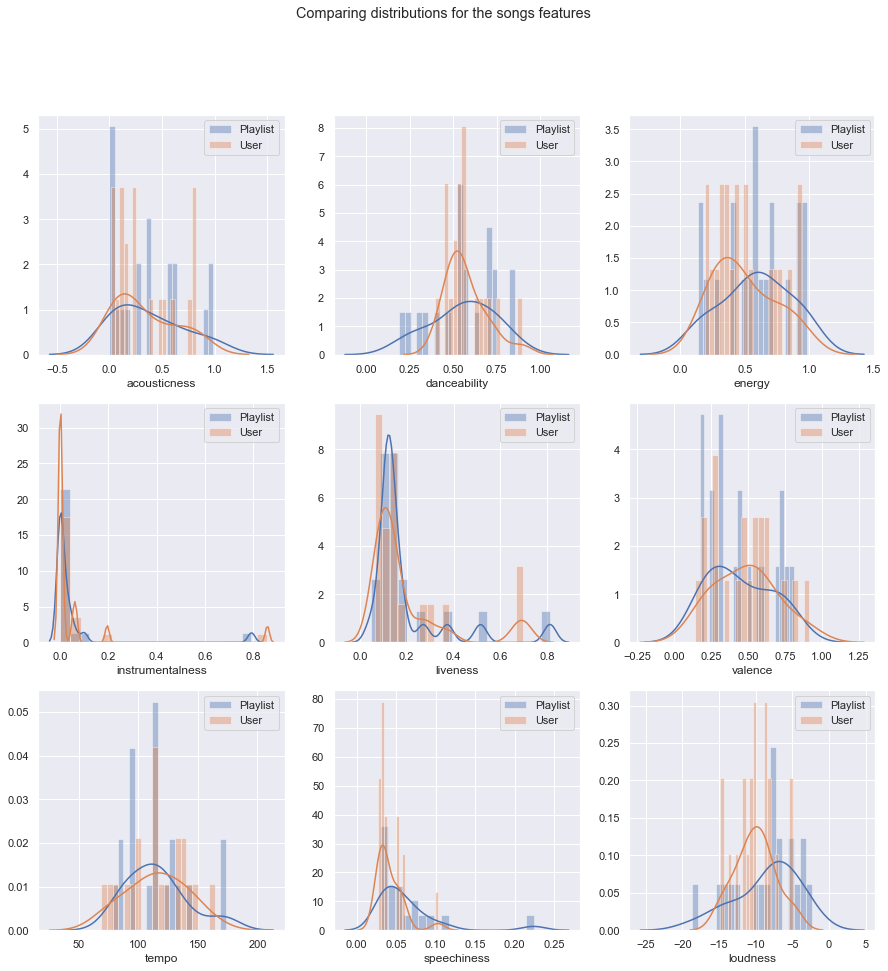

In [41]:
user_x_playlist = user_sampled.append(playlist)
plot_recomendations_similarities(user_x_playlist, columns_to_cluster)

### Exporting generated playlist

- To csv

In [42]:
playlist.drop(columns=columns_to_cluster_scaled, inplace=True)
playlist.to_csv('datasets/generated_playlists/andreaskeete_playlist.csv', index=False)

- To Spotify

In [213]:
my_user = '12144777067'

session = SpotifySession(my_user)



         User authentication requires interaction with your
         web browser. Once you enter your credentials and
         give authorization, you will be redirected to
         a url.  Paste that url you were directed to to
         complete the authorization.

     
Opened https://accounts.spotify.com/authorize?client_id=f4bd9bcb87724721ab5b0a9667f1ae52&response_type=code&redirect_uri=https%3A%2F%2Fedujtm.github.io%2Fdiversify%2Fredirect&scope=playlist-modify-private+user-library-read in your browser


Enter the the code pattern you were given: AQBE0kRk6w51WJnL1imsf-HCgu-a1xemJjIZqDyCNNBQP9AR9qdqf-UKGkiHUeh_xj49erITCzFYX-v5mUQiusGMgBhHTVta9oAkX0NOkyA6CCCA6wtPJsj-69z61UfSG3j9GxgmpVGZv2Y8NaLErGHtSxSyrxkqnXoWIcK3gOyie3nQgNJbPUGEViWjDeILgs9J9DxVH0H8I9DPdvyaW2gVlD0jWjxxwYHQKWWfPJSjWr77-jvNEB48Ig




In [214]:
session.tracks_to_playlist(trackids=playlist['id'], name='My Playlist 2.0')

### Some possible improvements

- Sampling dataset
- Using more or less features
- Using more or less clusters
- Using different scaler
- Increase train dataset size
- Decrease playlist size
- Take off random_state attributes
- Use another clustering algorithm